## Figure 1:  Co-expressed genes share biological function and regulatory architecture

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
import ast
from tqdm.auto import tqdm 
import networkx as nx
from scipy.stats import spearmanr
from matplotlib.colors import LinearSegmentedColormap



tqdm.pandas()

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_null_clusters import * 

# set higher figure resolution
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

#### b) number of clusters across tissues

In [2]:
# load in the clusters data
clusters = load_across_tissues(config, load_cluster)

# remove cross mappable 
# clusters_annotated = load_across_tissues(config, load_clusters_annotated)
# cross_map_ids = clusters_annotated[clusters_annotated['has_cross_map']]['cluster_id']
# clusters = remove_cross_map(clusters, cross_map_ids)

# make a palette
tissue_ids = load_tissue_ids(config)
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))

# get total number of clusters and genes in clusters
cluster_counts = clusters.groupby('tissue_id').agg({'N_genes':sum, 'Transcripts':'nunique'})

# get total number of expressed genes
num_expressed_genes = [len(load_expression(config, tissue_id)) for tissue_id in tissue_ids]
cluster_counts['expressed_genes'] = num_expressed_genes

In [139]:
gtex_tissue_dict = {
    "Adipose_Subcutaneous": "#FFA54F",
    "Adipose_Visceral_Omentum": "#EE9A00",
    "Artery_Tibial": "#FF0000",
    "Cells_Cultured_fibroblasts": "#9AC0CD",
    "Esophagus_Mucosa": "#8B7355",
    "Esophagus_Muscularis": "#CDAA7D",
    "Lung": "#9ACD32",
    "Muscle_Skeletal": "#7A67EE",
    "Nerve_Tibial": "#FFD700",
    "Skin_Not_Sun_Exposed_Suprapubic": "#3A5FCD",
    "Skin_Sun_Exposed_Lower_leg": "#1E90FF",
    "Thyroid": "#008B45",
    "Whole_Blood": "#FF00FF"
}

gtex_tissue_pal = sns.color_palette(list(gtex_tissue_dict.values()))
gtex_tissue_pal_df = pd.DataFrame(pd.Series(gtex_tissue_dict), columns=['hex']).reset_index(names=['tissue_id'])
gtex_tissue_pal

[(1.0, 0.6470588235294118, 0.30980392156862746),
 (0.9333333333333333, 0.6039215686274509, 0.0),
 (1.0, 0.0, 0.0),
 (0.6039215686274509, 0.7529411764705882, 0.803921568627451),
 (0.5450980392156862, 0.45098039215686275, 0.3333333333333333),
 (0.803921568627451, 0.6666666666666666, 0.49019607843137253),
 (0.6039215686274509, 0.803921568627451, 0.19607843137254902),
 (0.47843137254901963, 0.403921568627451, 0.9333333333333333),
 (1.0, 0.8431372549019608, 0.0),
 (0.22745098039215686, 0.37254901960784315, 0.803921568627451),
 (0.11764705882352941, 0.5647058823529412, 1.0),
 (0.0, 0.5450980392156862, 0.27058823529411763),
 (1.0, 0.0, 1.0)]

/local/scratch/klawren/slrmtmp.47456050/ipykernel_38355/1869419691.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)
/local/scratch/klawren/slrmtmp.47456050/ipykernel_38355/1869419691.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


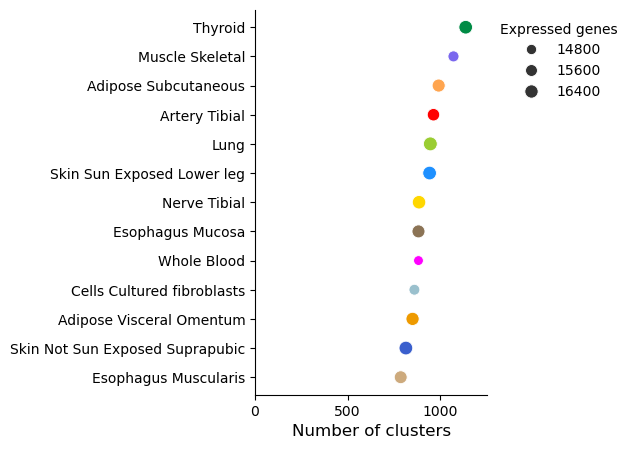

In [297]:
# plot showing number of clusters in each tissue
fig, ax = plt.subplots(figsize=(3,5))
ax = sns.scatterplot(cluster_counts.sort_values('Transcripts', ascending=False),hue_order=tissue_ids, x='Transcripts', hue='tissue_id', y='tissue_id', palette=gtex_tissue_pal, ax=ax, size='expressed_genes', sizes=(50, 100))
ax.set_xlim((0, ax.get_xlim()[1]+100))
ax.set_xticks([0,500,1000])
ax.set_xlabel('Number of clusters', fontsize=12)
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Keep only sample_size legend entries
handles, labels = ax.get_legend_handles_labels()
new_handles = []
new_labels = []
for handle, label in zip(handles, labels):
    if label.isnumeric():  # Assuming sample_size will be numeric and thus its labels will be numerical
        new_handles.append(handle)
        new_labels.append(label)
ax.legend(new_handles[::2], new_labels[::2], title='Expressed genes', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

plt.tight_layout() 
plt.show()


#### c) histogram of size distribution of clusters


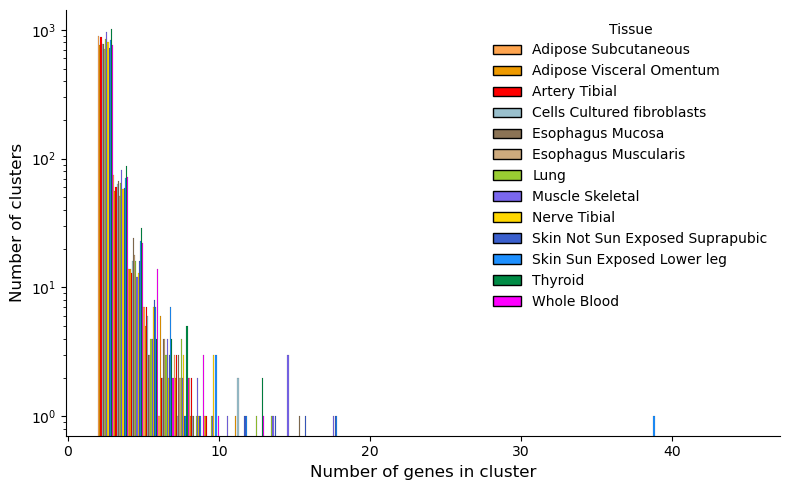

In [300]:
fig, ax = plt.subplots(figsize=(8,5))
show_legend=True

sns.histplot(clusters, x='N_genes', ax=ax, hue='tissue_id', alpha=1, multiple='dodge',
             hue_order=tissue_ids, palette=gtex_tissue_pal, bins=np.arange(2, clusters['N_genes'].max()), legend=show_legend)
ax.set_ylabel('Number of clusters', fontsize=12)
ax.set_xlabel('Number of genes in cluster', fontsize=12)
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize the legend
if show_legend:
    legend = ax.get_legend()
    new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
    for t, new_label in zip(legend.texts, new_labels):
        t.set_text(new_label)
    legend.get_frame().set_visible(False)
    legend.set_title("Tissue")


# Show plot
plt.tight_layout() 
plt.show()


### examples of clusters

In [ ]:
gid_gencode, full_gencode = load_gencode()

In [247]:
def plot_cluster(example_cluster):
    # gene gene ids sorted by tss start
    sorted_cluster = gid_gencode.loc[example_cluster['cluster_id'].split('_')].sort_values('tss_start')
    sorted_gene_ids = sorted_cluster.index.values
    # get normed expression 
    expression = load_cluster_expression(config, example_cluster['Tissue'])
    cluster_expression = expression[(expression['cluster_id']==example_cluster['cluster_id'])].set_index('egene_id').loc[sorted_gene_ids]
    # get correlation of expression
    sample_ids = cluster_expression.columns[cluster_expression.columns.str.contains('GTEX')]
    cluster_corr, cluster_pvalue = spearmanr(cluster_expression[sample_ids], axis=1)
    # make df wtih readable gene names
    cluster_corr = pd.DataFrame(cluster_corr, index=sorted_cluster['gene_name'].values, columns=sorted_cluster['gene_name'].values)

    # make corr plot
    cmap = LinearSegmentedColormap.from_list('mycmap', [(0, '#c4553aff'), (.5, 'white'), (1, '#3e8093ff')])
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cluster_corr, mask=np.triu(np.ones_like(cluster_corr), k=0),
                cmap=cmap, vmin=-1, vmax=1, ax=ax, cbar_kws={'label':'Spearman Corrleation'}, xticklabels=True, yticklabels=True, cbar=False)
    ax.tick_params("y", rotation=0) 
    plt.show()

In [273]:
clusters[(clusters['N_genes'] > 5)&(clusters['Mean_neg_cor'] < -.2)]

,N_genes,Transcripts,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue,cluster_id,tissue_id,gene_id,partner_gene_id
286,7,"ENSG00000204287.13,ENSG00000198502.5,ENSG00000...",0.761905,0.207344,0.447171,-0.272312,6,Adipose_Subcutaneous,ENSG00000179344.16_ENSG00000196126.11_ENSG0000...,Adipose_Subcutaneous,"[ENSG00000179344.16, ENSG00000196126.11, ENSG0...","[ENSG00000179344.16, ENSG00000196126.11, ENSG0..."
2138,7,"ENSG00000204287.13,ENSG00000198502.5,ENSG00000...",0.761905,0.227551,0.449744,-0.216834,6,Artery_Tibial,ENSG00000179344.16_ENSG00000196126.11_ENSG0000...,Artery_Tibial,"[ENSG00000179344.16, ENSG00000196126.11, ENSG0...","[ENSG00000179344.16, ENSG00000196126.11, ENSG0..."
2139,6,"ENSG00000204540.10,ENSG00000204538.3,ENSG00000...",0.733333,0.055026,0.411275,-0.256692,6,Artery_Tibial,ENSG00000137310.11_ENSG00000204525.16_ENSG0000...,Artery_Tibial,"[ENSG00000137310.11, ENSG00000204525.16, ENSG0...","[ENSG00000137310.11, ENSG00000204525.16, ENSG0..."
3947,6,"ENSG00000204540.10,ENSG00000204538.3,ENSG00000...",0.800000,0.212654,0.431806,-0.225651,6,Esophagus_Mucosa,ENSG00000137310.11_ENSG00000204525.16_ENSG0000...,Esophagus_Mucosa,"[ENSG00000137310.11, ENSG00000204525.16, ENSG0...","[ENSG00000137310.11, ENSG00000204525.16, ENSG0..."
5613,7,"ENSG00000204287.13,ENSG00000198502.5,ENSG00000...",0.714286,0.130746,0.416188,-0.333097,6,Lung,ENSG00000179344.16_ENSG00000196126.11_ENSG0000...,Lung,"[ENSG00000179344.16, ENSG00000196126.11, ENSG0...","[ENSG00000179344.16, ENSG00000196126.11, ENSG0..."
6616,7,"ENSG00000204287.13,ENSG00000198502.5,ENSG00000...",0.714286,0.211863,0.427581,-0.219573,6,Muscle_Skeletal,ENSG00000179344.16_ENSG00000196126.11_ENSG0000...,Muscle_Skeletal,"[ENSG00000179344.16, ENSG00000196126.11, ENSG0...","[ENSG00000179344.16, ENSG00000196126.11, ENSG0..."
7630,7,"ENSG00000204287.13,ENSG00000198502.5,ENSG00000...",0.714286,0.177728,0.402159,-0.271135,6,Nerve_Tibial,ENSG00000179344.16_ENSG00000196126.11_ENSG0000...,Nerve_Tibial,"[ENSG00000179344.16, ENSG00000196126.11, ENSG0...","[ENSG00000179344.16, ENSG00000196126.11, ENSG0..."
8470,7,"ENSG00000204301.6,ENSG00000204287.13,ENSG00000...",0.714286,0.220044,0.327078,-0.234855,6,Skin_Not_Sun_Exposed_Suprapubic,ENSG00000179344.16_ENSG00000196126.11_ENSG0000...,Skin_Not_Sun_Exposed_Suprapubic,"[ENSG00000179344.16, ENSG00000196126.11, ENSG0...","[ENSG00000179344.16, ENSG00000196126.11, ENSG0..."
9305,6,"ENSG00000204287.13,ENSG00000198502.5,ENSG00000...",0.800000,0.192237,0.344292,-0.415985,6,Skin_Sun_Exposed_Lower_leg,ENSG00000179344.16_ENSG00000196126.11_ENSG0000...,Skin_Sun_Exposed_Lower_leg,"[ENSG00000179344.16, ENSG00000196126.11, ENSG0...","[ENSG00000179344.16, ENSG00000196126.11, ENSG0..."
10358,7,"ENSG00000204287.13,ENSG00000198502.5,ENSG00000...",0.714286,0.159751,0.436810,-0.290470,6,Thyroid,ENSG00000179344.16_ENSG00000196126.11_ENSG0000...,Thyroid,"[ENSG00000179344.16, ENSG00000196126.11, ENSG0...","[ENSG00000179344.16, ENSG00000196126.11, ENSG0..."


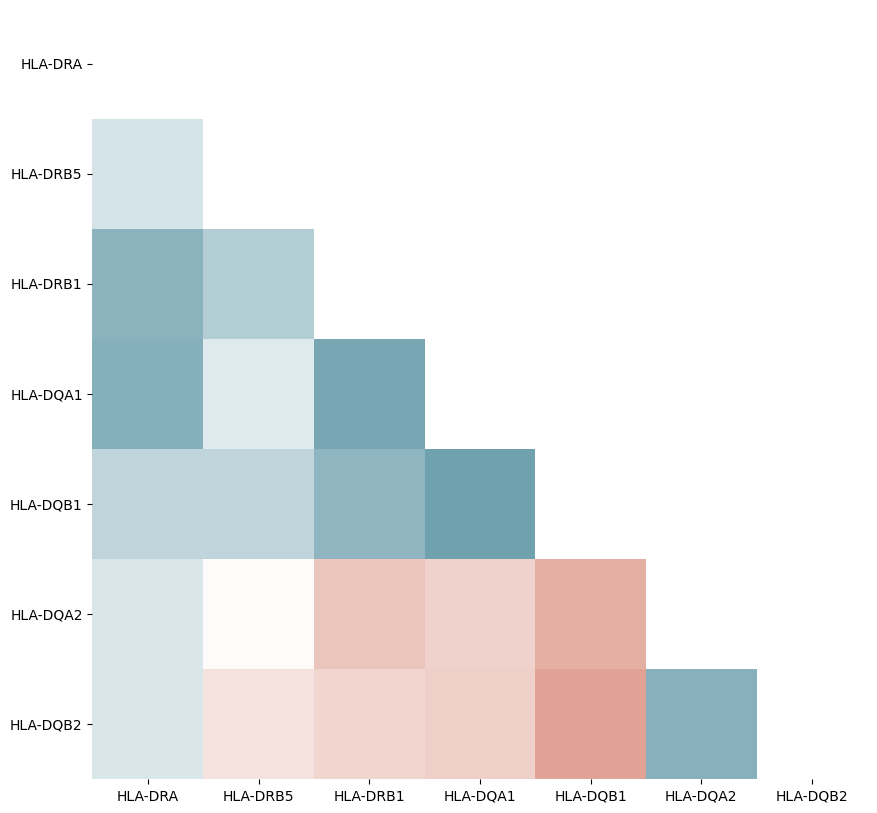

In [283]:
# large negative clusters (hla genes) in thyroid
plot_cluster(clusters.iloc[10358])

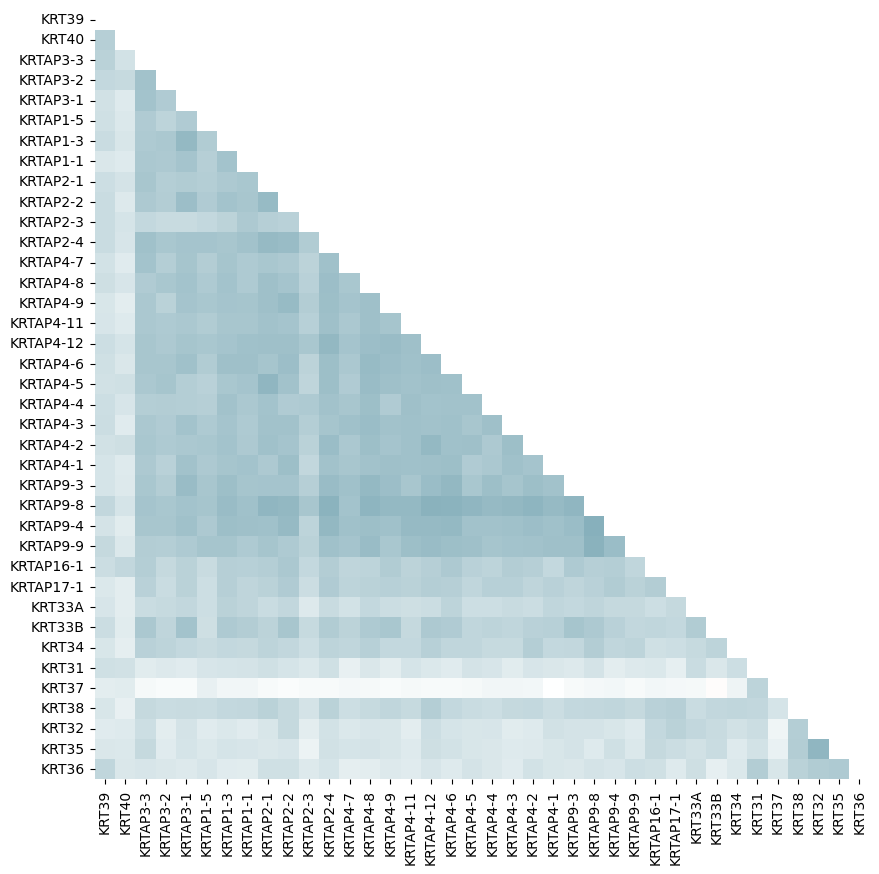

In [ ]:
# largest cluster (keratin genes)
plot_cluster(clusters.iloc[9757])

#### d) Forest plot, split by positive and negative with fraction of clusters in each category

In [5]:
# get just the ones with matched enahncer
enhancer_tissue_ids = ['Artery_Tibial', 'Cells_Cultured_fibroblasts', 'Lung', 'Muscle_Skeletal', 'Skin_Not_Sun_Exposed_Suprapubic', 'Skin_Sun_Exposed_Lower_leg', 'Thyroid']
combined_clusters = load_across_tissues(config, load_clusters_annotated, tissue_ids = enhancer_tissue_ids)
def load_all_multigene_null(config, tissue_id):
    return pd.concat([load_null_clusters_annotated(config, tissue_id, num_genes) for num_genes in [2,3,4,5]])
combined_multigene_nulls =  load_across_tissues(config, load_all_multigene_null, tissue_ids = enhancer_tissue_ids)

# exclude highly cross mappable genes and add columns
combined_clusters = combined_clusters[~combined_clusters['has_cross_map']]
combined_clusters['has_multiple_abc_genes'] = combined_clusters['num_abc_genes'] > 1
combined_clusters['log_size'] = np.log10(combined_clusters['cluster_tss_size'])
combined_multigene_nulls = combined_multigene_nulls[~combined_multigene_nulls['has_cross_map']]
combined_multigene_nulls['has_multiple_abc_genes'] = combined_multigene_nulls['num_abc_genes'] > 1
combined_multigene_nulls['log_size'] = np.log10(combined_multigene_nulls['cluster_tss_size'])


# make nulls  

# make one without distance matching
multitissue_abc_largerclusters_df = pd.concat([combined_clusters, combined_multigene_nulls], keys=['cluster', 'null'], names=['type', 'idx']).reset_index()
multitissue_abc_largerclusters_df['is_cluster'] = multitissue_abc_largerclusters_df['type']=='cluster'

# make one with distance matching
multitissue_abc_resamp_largerclusters_nulls = []
for num_genes in combined_multigene_nulls['N_genes'].unique():
    cluster_num_genes = combined_clusters[(combined_clusters['N_genes']==num_genes)]
    # don't bother to match if too few clusters of this size, just discard null
    if len(cluster_num_genes) > 2:
        null_num_genes = combined_multigene_nulls[(combined_multigene_nulls['N_genes']==num_genes)]
        multitissue_abc_resamp_largerclusters_nulls.append(get_resamp_null_cluster(null_num_genes, cluster_num_genes, number_null=5000*len(enhancer_tissue_ids), plot=False))

multitissue_abc_resamp_largerclusters_df = pd.concat([combined_clusters, pd.concat(multitissue_abc_resamp_largerclusters_nulls)], keys=['cluster', 'null'], names=['type', 'idx']).reset_index()
multitissue_abc_resamp_largerclusters_df['is_cluster'] = multitissue_abc_resamp_largerclusters_df['type']=='cluster'

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annota

In [21]:
# get odds dfs for all, top positive, and negative clusters

# get all neg and matching number of top pos
# neg_cutoff = -.01
# num_neg = len(combined_clusters[combined_clusters['Mean_neg_cor'] < neg_cutoff])
# pos_cutoff = combined_clusters['Mean_pos_cor'].sort_values(ascending=False).iloc[num_neg] # match number of pos cutoff to number in negative

# get top 100 pos and neg
top_num = 200
pos_cutoff = combined_clusters['Mean_pos_cor'].sort_values(ascending=False).iloc[top_num]
neg_cutoff = combined_clusters['Mean_neg_cor'].sort_values(ascending=True).iloc[top_num]


noresamp_cols = ['has_bidirectional_promoter']
noresamp_odds_positive = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['Mean_pos_cor']>pos_cutoff)) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')
noresamp_odds_all = get_odds_df(multitissue_abc_largerclusters_df, column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')
noresamp_odds_negative = get_odds_df(multitissue_abc_largerclusters_df[((multitissue_abc_largerclusters_df['type']=='cluster')&(multitissue_abc_largerclusters_df['Mean_neg_cor']<neg_cutoff)) | (multitissue_abc_largerclusters_df['type']=='null')], column_list = noresamp_cols, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')

resamp_column_list = ['has_tads_tss', 
                      'has_paralog', 
                      'has_shared_go_any',
                      'has_ctcf_peak',
                      'has_shared_enhancer']

bool_filter_list = ['has_shared_enhancer']

resamp_odds_positive = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['Mean_pos_cor']>pos_cutoff)) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes', label_col='is_cluster') 
resamp_odds_all = get_odds_df(multitissue_abc_resamp_largerclusters_df, column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')
resamp_odds_negative = get_odds_df(multitissue_abc_resamp_largerclusters_df[((multitissue_abc_resamp_largerclusters_df['type']=='cluster')&(multitissue_abc_resamp_largerclusters_df['Mean_neg_cor']<neg_cutoff)) | (multitissue_abc_resamp_largerclusters_df['type']=='null')], column_list=resamp_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes', label_col='is_cluster')


has_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.010150
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               132338
Model:                          Logit   Df Residuals:                   132335
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Jan 2025   Pseudo R-squ.:                  0.1038
Time:                        11:35:43   Log-Likelihood:                -1343.2
converged:                       True   LL-Null:                       -1498.8
Covariance Type:            nonrobust   LLR p-value:                 2.732e-68
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.0121      0.316

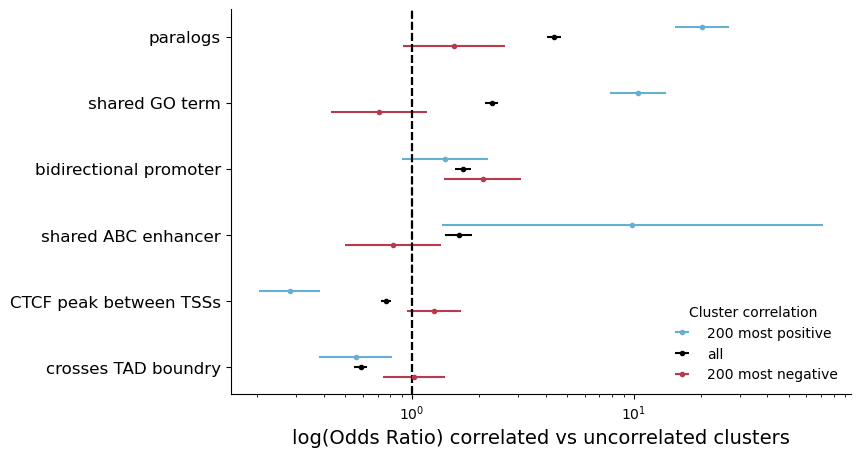

In [301]:
# combined, resampled and nonresampled columns
col_order = ['has_tads_tss', 'has_ctcf_peak', 'has_shared_enhancer', 'has_bidirectional_promoter', 'has_shared_go_any', 'has_paralog']
odds_negative = pd.concat([noresamp_odds_negative, resamp_odds_negative]).loc[col_order] 
odds_all = pd.concat([noresamp_odds_all, resamp_odds_all]).loc[col_order] 
odds_positive = pd.concat([noresamp_odds_positive, resamp_odds_positive]).loc[col_order] 

fig, ax = plt.subplots(figsize=(8,5))

# make the plot
make_log_odds_plot_multiple([odds_negative, odds_all, odds_positive], 
                             labels=['200 most negative', 'all', '200 most positive',], 
                             colors = sns.color_palette('blend:#B83A4B,k,#67AFD2', n_colors=3), 
                             add_annotations=False, offset=.15, ax=ax)

ax.set_xlabel('log(Odds Ratio) correlated vs uncorrelated clusters', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(fontsize=3) 
ax.set_yticklabels(np.array(['paralogs',  'shared GO term',  'bidirectional promoter', 'shared ABC enhancer',  'CTCF peak between TSSs',  'crosses TAD boundry'])[::-1], fontsize=12)

# customize the legend
legend = ax.get_legend()
legend.get_frame().set_visible(False)
legend.set_title("Cluster correlation")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1))


### cluster sharing across tissues

In [64]:
# for each pair of genes, are they in a cluster in any other set of tisues?
clusters['gene_id'] = clusters['cluster_id'].str.split('_')
clusters['partner_gene_id'] = clusters['cluster_id'].str.split('_')
clusters_exploded = clusters.explode('gene_id').explode('partner_gene_id')
# remove ones where genes are partnered to themselves 
clusters_exploded = clusters_exploded[~(clusters_exploded['gene_id'] == clusters_exploded['partner_gene_id'])]
# group by pairs of genes
gene_partners = clusters_exploded.groupby(['gene_id', 'partner_gene_id']).agg({'cluster_id':'unique', 'tissue_id':'unique'})

def get_pretty_tissue_id(tissue_id_list):
    return [tissue_id.replace('_', ' ') for tissue_id in tissue_id_list]
gene_partners['tissue_id_pretty'] = gene_partners['tissue_id'].apply(get_pretty_tissue_id)

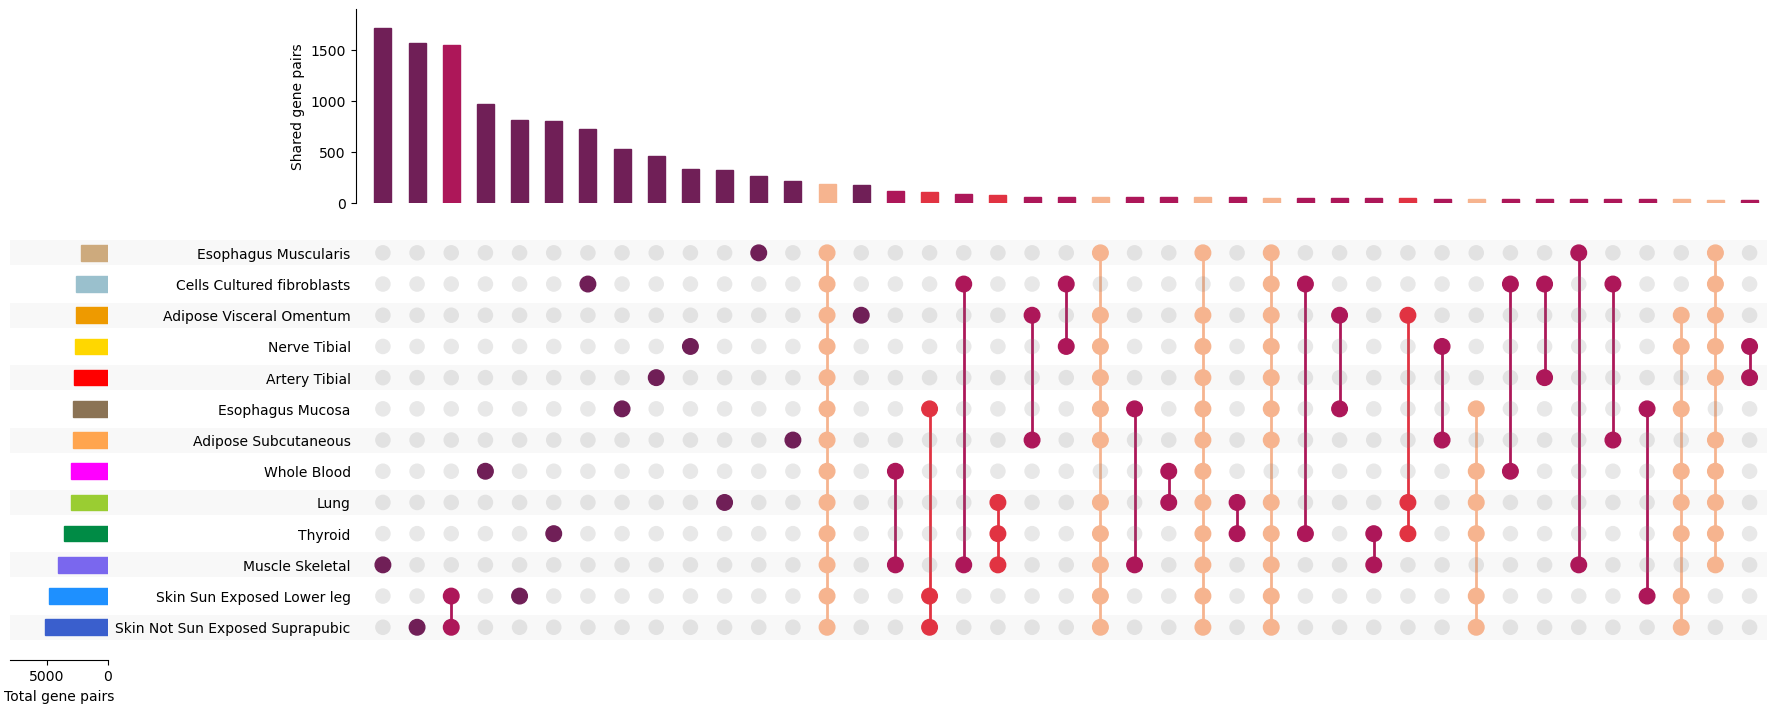

In [ ]:
# make an upset plot showing pair sharing
upset = up.UpSet(up.from_memberships(gene_partners['tissue_id_pretty']), subset_size='count', min_subset_size=30, show_counts=False, 
                 sort_by="cardinality", facecolor="grey", totals_plot_elements=3)
for i in range(6):
    upset.style_subsets(min_degree=i, facecolor=sns.color_palette("rocket")[i])

# style the instersection plot
plot_result = upset.plot()
intersection_plot = plot_result["intersections"]
intersection_plot.set_ylabel("Shared gene pairs")
intersection_plot.set_xlim(-.8, intersection_plot.get_xlim()[1])
intersection_plot.set_ylim(0, intersection_plot.get_ylim()[1]+100)
intersection_plot.grid(False)

# style the totals plot
totals_plot = plot_result["totals"]
totals_plot.set_xlim((8000, 0))
totals_plot.grid(False)
totals_plot.set_xlabel("Total gene pairs")
# change totals plot colors to match gtex tissues
gtex_tissue_pal_df['tissue_id_pretty'] = gtex_tissue_pal_df['tissue_id'].str.replace('_', ' ')
for bar, label in zip(plot_result["totals"].patches, totals_plot.get_yticklabels()):
    bar.set_color(gtex_tissue_pal_df[gtex_tissue_pal_df['tissue_id_pretty'] == label.get_text()]['hex'].iloc[0])  # Set the color based on the palette

plt.show()

### supp figure: cross mappable clusters

In [ ]:
clusters_annotated = load_across_tissues(config, load_clusters_annotated)
sns.histplot(clusters_annotated, x='num_cross_map', hue='has_cross_map', bins=np.arange(0, clusters_annotated['num_cross_map'].max()))

supp: pos vs neg

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


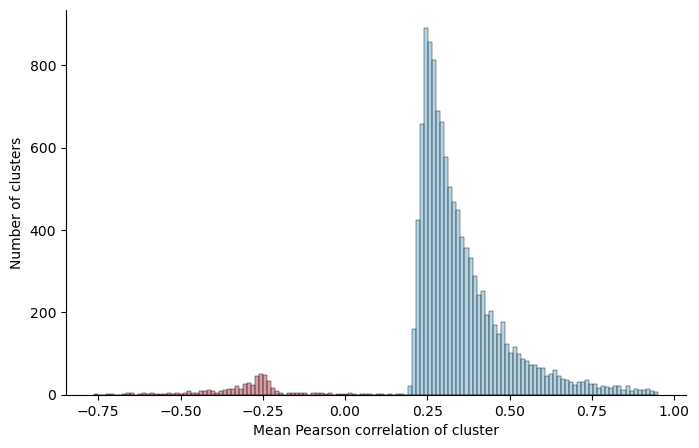

In [123]:
fig, ax = plt.subplots(figsize=(8,5))

clusters['has_pos_corr'] = clusters['Mean_cor'] > 0
sns.histplot(clusters, x='Mean_cor', hue='has_pos_corr', palette=({True:tissue_pal[-1], False:tissue_pal[0]}), ax=ax)
ax.set_ylabel('Number of clusters')
ax.set_xlabel('Mean Pearson correlation of cluster')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend().remove()
